# Testing the embedding extractor

Till now we have trained our siamese network and have seen how well it performs in **distinguishing images** of two different classes. But setting an **arbitrary threshold** distance to gauge the performance(accuracy) of our model is not a good and reliable technique.

Our aim is to convert each image to such an embedding/encoding such that same face images are close to each other and different face images are far, and during face recognition the classification will also be based on this principle only. Hence, we now guage the performance of the embeddings created by our model.

## Importing the libraries

In [ ]:
import numpy as np
import keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

## Loading the dataset

In [ ]:
TRAIN_DATAPATH = "/content/drive/MyDrive/AI Project/cropped_images_team1/train"
VAL_DATAPATH = "/content/drive/MyDrive/AI Project/cropped_images_team1/val"

In [ ]:
IMAGE_SIZE = (128, 128)
COLOR_MODE = "grayscale"
IMAGE_SHAPE = list(IMAGE_SIZE)+[3]
NUM_CLASSES = 4

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, brightness_range=(1.0, 1.3))
train_generator = train_datagen.flow_from_directory(TRAIN_DATAPATH,
                                        color_mode=COLOR_MODE,
                                        target_size=IMAGE_SIZE,
                                        seed=10)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(VAL_DATAPATH,
                                        color_mode=COLOR_MODE,
                                        target_size=IMAGE_SIZE,
                                        seed=10)


Found 32 images belonging to 4 classes.
Found 16 images belonging to 4 classes.


## Utility functions

In [ ]:
label_map = {v:k for k, v in train_generator.class_indices.items()}

In [ ]:
def getLabelFromClassIndex(index):
    return label_map[index]

In [ ]:
def convert_to_three_channeled(grayscale_batch):
    rgb_batch = np.repeat(grayscale_batch[..., np.newaxis], 3, -1)
    return rgb_batch

def datagen_to_np_array(generator):
    images, labels = [], []
    generator.reset()
    for i in range(len(generator)):
        batch_X, batch_Y = generator.next()
        images.append(batch_X)
        labels.append(batch_Y)
    images = np.concatenate(images, axis = 0)
    # print(images.shape)
    if(images.shape[-1] == 1):
        images = np.repeat(images, 3, axis=-1)

    labels = np.concatenate(labels, axis = 0)
    labels = np.argmax(labels, axis = 1)
    labels = np.array(list(map(getLabelFromClassIndex, labels)))
    return images, labels

## Loading the images into numpy arrays

In [ ]:
train_images, train_labels = datagen_to_np_array(train_generator)
val_images, val_labels = datagen_to_np_array(val_generator)
print("Training Images array shape: ", train_images.shape)
print("Training labels array shape: ", train_labels.shape)
print("Validation Images array shape: ", val_images.shape)
print("Validation labels array shape: ", val_labels.shape)

Training Images array shape:  (32, 128, 128, 3)
Training labels array shape:  (32,)
Validation Images array shape:  (16, 128, 128, 3)
Validation labels array shape:  (16,)


## Loading the Trained Embedding network model extracted from Siamese Network

In [ ]:
# Load the embedding network model
MODEL_PATH = "/content/drive/MyDrive/AI Project Repo/testrep/face-attendance/embeddings_models/team_data_models/embeddingModel_mobilenet_siamese_98Acc"
model = load_model(MODEL_PATH, compile=False)
model.summary()

Model: "base_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_input (InputLayer)     [(None, 128, 128, 3)]     0         
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 150)               192150    
                                                                 
 dropout_5 (Dropout)         (None, 150)              

## Extracting the embeddings for training and validation images

In [ ]:
train_embeddings = model(train_images).numpy()
val_embeddings = model(val_images).numpy()

## Testing the embeddings generated by the model

To test our embeddings we will train a K-Neighbors Classifier on the training embeddings and try to predict the classes for validation embeddings. This will help us in evaluating the quality of embeddings generated by our siamese model. 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
knn.fit(train_embeddings, train_labels)

KNeighborsClassifier(weights='distance')

In [ ]:
val_pred_labels = knn.predict(val_embeddings)

              precision    recall  f1-score   support

    anshuman       1.00      1.00      1.00         4
       kirti       0.80      1.00      0.89         4
    monalisa       1.00      1.00      1.00         5
     sattwik       1.00      0.67      0.80         3

    accuracy                           0.94        16
   macro avg       0.95      0.92      0.92        16
weighted avg       0.95      0.94      0.93        16



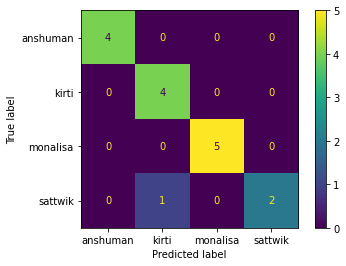

In [ ]:
cmd = ConfusionMatrixDisplay.from_predictions(val_labels, val_pred_labels)
print(classification_report(val_labels, val_pred_labels))

We can see from above that only one validation image was misclassified. Hence, the learnt embedding extractor is able to produce desirable embeddings.

## Visualize predictions

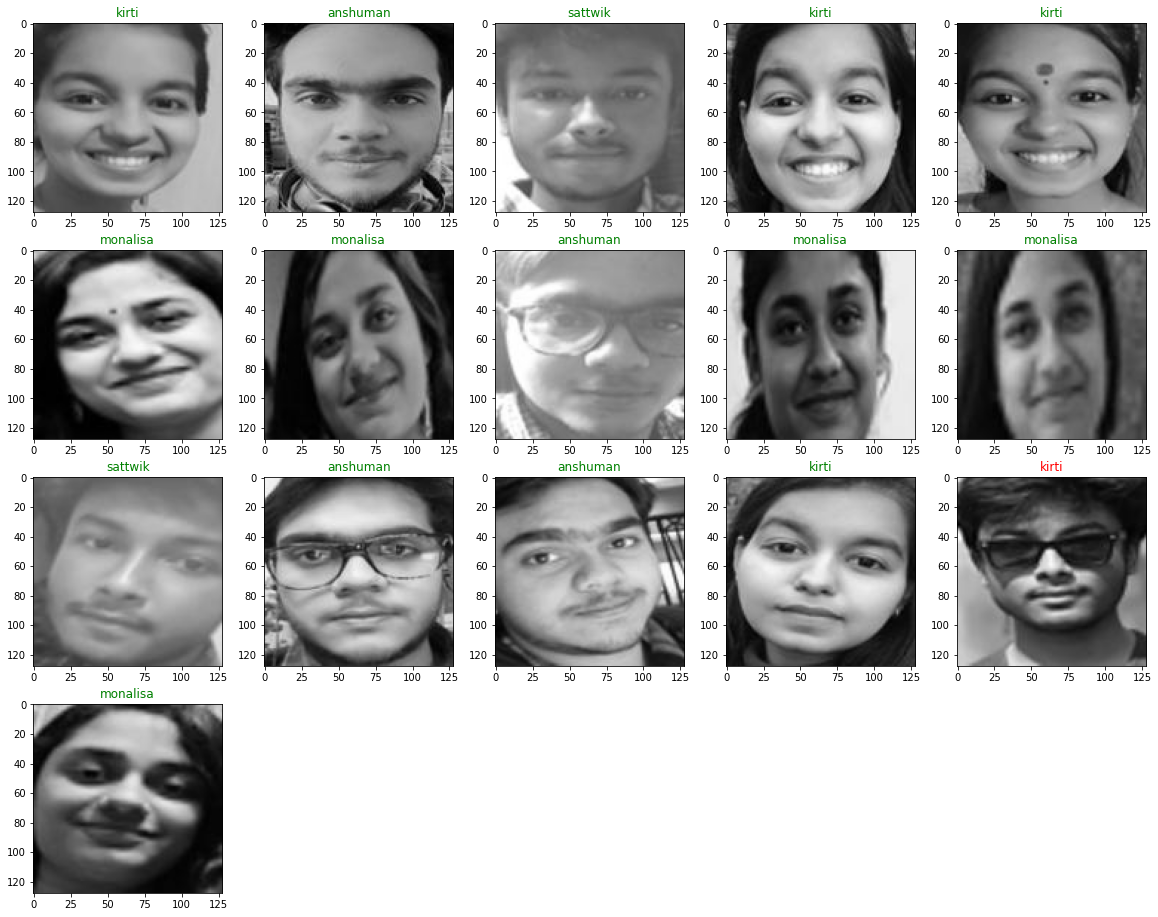

In [ ]:
n = len(val_images)
rows = np.ceil(n/5)
indices = np.arange(0, n)
plotNo = 1
plt.figure(figsize=(20, 4*rows))
for i in indices:
    ax = plt.subplot(rows, 5, plotNo)

    plt.imshow(val_images[i])  
    plt.title(val_labels[i])
    if(val_labels[i] == val_pred_labels[i]):
        ax.set_title(val_pred_labels[i], fontdict={'color':'green'})
    else:
        ax.set_title(val_pred_labels[i], fontdict={'color':'red'})

    plotNo += 1